# Settings

Installed scrublet by running `pip install scrublet --user` in the terminal (not sudo).

In [1]:
import pandas
import os
import sys
import gc
import subprocess
import concurrent.futures
from multiprocessing import Pool
from datetime import date
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Visual variables
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

In [3]:
gc.enable()

In [4]:
# Setup variables
base_dir = "/nfs/lab/projects/COVID_mouse/"
cellranger_dir = base_dir + "cell.ranger/"
step1_dir = base_dir + "seurat/1_pre.processing/"
step3_dir = base_dir + "seurat/3_scrublet/"


In [5]:
# Grab samples
os.chdir(cellranger_dir)
sample_ls = os.listdir()
sample_ID_ls = [s.replace("_1_2", "") for s in sample_ls]
sample_ID_ls = [s.replace("_JB_", "_") for s in sample_ID_ls]
sample_ID_ls = [s.replace("_MM_", "_") for s in sample_ID_ls]
sample_ID_ls = [s.replace("_QY_", "_") for s in sample_ID_ls]
print(sample_ls)
print(sample_ID_ls)

['5_RBD2', '10_G1C1', '4_RBD1', '8_G1B2', '12_G1C3', '7_G1B1', '3_GFP3', '2_GFP2', '11_G1C2', '9_G1B3', '1_GFP1', '6_RBD3']
['5_RBD2', '10_G1C1', '4_RBD1', '8_G1B2', '12_G1C3', '7_G1B1', '3_GFP3', '2_GFP2', '11_G1C2', '9_G1B3', '1_GFP1', '6_RBD3']


In [6]:
def run_scrublet(i):
    gc.collect()
    # Set sample variable
    sample = sample_ls[i]
    sample_ID = sample_ID_ls[i]
    print("Workin on: " + sample_ID)
    # Load data
    counts_matrix = scipy.io.mmread(step3_dir + sample_ID + '_matrix.mtx').T.tocsc()
    genes = np.array(scr.load_genes(step3_dir + sample_ID + '_genes.tsv', delimiter='\t', column=0))

    scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                                  min_cells=3, 
                                                                  min_gene_variability_pctl=85, 
                                                                  n_prin_comps=30)

    # Get automatic threshold
    auto_threshold = scrub.threshold_

    # Save the automatic threshold to file
    with open(step3_dir + sample_ID + '_auto_threshold.txt', 'w') as f:
        f.write(str(auto_threshold))

    # Pull out predicted doublets from Scrublet
    predicted_doublets = scrub.call_doublets() 

    # Write out results to a new file
    barcodes_fp = step3_dir + sample_ID + '_barcodes.tsv'
    with open(barcodes_fp, 'r') as f:
        with open(step3_dir + sample_ID + '_scrublet_predicted_doublets.txt', 'w') as o:
            counter=0
            for line in f:
                o.write('\t'.join((line.strip(), str(predicted_doublets[counter]), str(doublet_scores[counter]), '\n')))
                counter+=1

    # Delete object and continue loop
    del scrub

In [7]:
num_cores = 1 # set the number of cores to use here

with Pool(processes=num_cores) as pool:
    pool.map(run_scrublet, range(len(sample_ls)))

Workin on: 5_RBD2
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 56.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.2%
Elapsed time: 26.0 seconds
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 56.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.2%
Workin on: 10_G1C1
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 48.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.1%
Elapsed time: 23.8 seconds
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 48.8%
Overa

# Adjust thresholding when needed

In [10]:
sample_ls

['5_RBD2',
 '10_G1C1',
 '4_RBD1',
 '8_G1B2',
 '12_G1C3',
 '7_G1B1',
 '3_GFP3',
 '2_GFP2',
 '11_G1C2',
 '9_G1B3',
 '1_GFP1',
 '6_RBD3']

In [11]:
# Samples I don't like: 3_GFP3 6_RBD3 

Workin on: 6_RBD3
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 45.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.1%
Elapsed time: 14.2 seconds


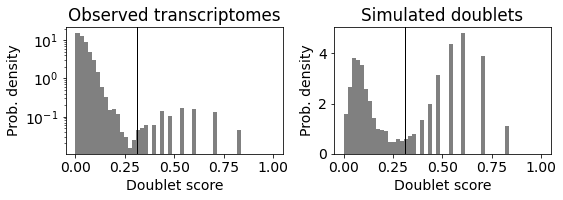

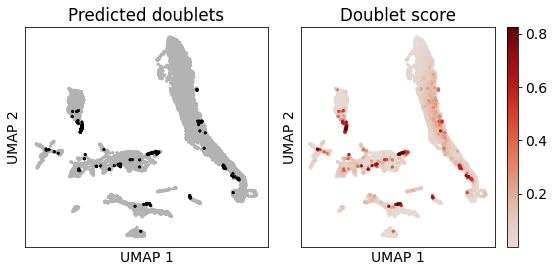

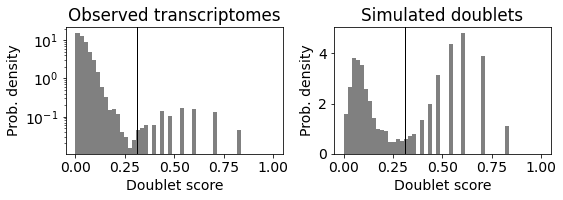

In [24]:
gc.collect()
# Set sample variable
sample_ID = "6_RBD3"
print("Workin on: " + sample_ID)
# Load data
counts_matrix = scipy.io.mmread(step3_dir + sample_ID + '_matrix.mtx').T.tocsc()
genes = np.array(scr.load_genes(step3_dir + sample_ID + '_genes.tsv', delimiter='\t', column=0))

scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                                min_cells=3, 
                                                                min_gene_variability_pctl=85, 
                                                             n_prin_comps=30)
scrub.plot_histogram() 
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);

# Plot doublets distribution
scrub.plot_histogram()
plt.savefig(step3_dir + sample_ID + '_scrub.plot.png')

In [ ]:
print("Fine-tuning: " + sample_ID)
thresh = 0.25
# Set manual treshold here, trying to split the 2 populations
# Pull out predicted doublets from Scrublet
predicted_doublets = scrub.call_doublets(threshold=thresh) 
scrub.plot_histogram()

# Get automatic threshold
auto_threshold = scrub.threshold_

# Plot doublets distribution
scrub.plot_histogram()
plt.savefig(step3_dir + sample_ID + '_scrub.plot.png')

# Check where doublets fall
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);

# overwrite the automatic threshold to file
with open(step3_dir + sample_ID + '_auto_threshold.txt', 'w') as f:
    f.write(str(auto_threshold))
    
# Write out results to a new file
barcodes_fp = step3_dir + sample_ID + '_barcodes.tsv'
with open(barcodes_fp, 'r') as f:
    with open(step3_dir + sample_ID + '_scrublet_predicted_doublets.txt', 'w') as o:
        counter=0
        for line in f:
            o.write('\t'.join((line.strip(), str(predicted_doublets[counter]), str(doublet_scores[counter]), '\n')))
            counter+=1
# Detected doublet rate reports how many doublets

Fine-tuning: 6_RBD3
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 49.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.3%
